In [1]:
# Import
import sys, os
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import f1_score, recall_score, precision_score

from statsmodels.tsa.seasonal import STL, seasonal_decompose

from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from pyod.models.xgbod import XGBOD
from pyod.models.suod import SUOD
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.copod import COPOD
from pyod.models.pca import PCA

from adtk.visualization import plot
from adtk.detector import AutoregressionAD, QuantileAD, InterQuartileRangeAD, GeneralizedESDTestAD, PersistAD, LevelShiftAD, VolatilityShiftAD, PcaAD, MinClusterDetector
from adtk.data import validate_series
from adtk.metrics import iou

2022-09-11 09:21:58.473761: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-11 09:21:58.476210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-11 09:21:58.476219: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Functions

In [2]:
def plot_outlier(predicted_df):
    fig, ax = plt.subplots(figsize=(12,4))
    outlier_points = predicted_df.loc[predicted_df['prediction'] == 1] #anomaly
    ax.plot(predicted_df.index, predicted_df['value'], color='blue', label = 'Normal')
    ax.scatter(outlier_points.index, outlier_points['value'], color='red', label = 'Anomaly')
    plt.legend()
    plt.show()

In [3]:
def print_metrics(original_df, predicted_df):
    print("F1 Score:", f1_score(original_df['label'], predicted_df['prediction']))
    print("Recall:", recall_score(original_df['label'], predicted_df['prediction']))
    print("Precision:", precision_score(original_df['label'], predicted_df['prediction']))

## Load & Preprocess Data

In [15]:
# Merging all files and making the dataframe
# df = pd.concat(map(pd.read_csv, glob.glob(os.path.join("./data" , "*.csv"))), ignore_index= True)
df = pd.read_csv('data/30.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.set_index('timestamp')
# df = df.asfreq(freq='T')
# df = df.interpolate()
df['label'] = df.label.astype(int)

#### Lag Features

In [16]:
df['lag_1'] = df['value'].shift(1)
df['lag_2'] = df['value'].shift(2)
df['lag_3'] = df['value'].shift(3)
df['lag_4'] = df['value'].shift(4)
df.fillna(0, inplace=True)

#### Decomposition Features

In [17]:
decompose = STL(df['value'], period=2).fit()
df['resid'] = decompose.resid
df['trend'] = decompose.trend
df['seasonal'] = decompose.seasonal
# decompose.plot()
# plt.show()

In [18]:
# df_hourly = df.resample('H').mean()

#### Feature Selection

In [19]:
# scaler = StandardScaler()
# np_scaled = scaler.fit_transform(df['value'].values.reshape(-1, 1))
# df['scaled'] = np_scaled
data = df[['value', 'lag_1', 'lag_2', 'resid', 'label']]

In [20]:
validate_df = validate_series(data)

In [21]:
# validate_test = validate_series(df[['label']])

## PCA

## SUOD

In [30]:
detector_list = [LOF(n_neighbors=15), LOF(n_neighbors=20),
                 LOF(n_neighbors=25), LOF(n_neighbors=35),
                 COPOD(), IForest(n_estimators=100),
                 IForest(n_estimators=200)]

In [31]:
clf = SUOD(base_estimators=detector_list, n_jobs=4, combination='average', verbose=False)
clf.fit(validate_df)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.4s finished


SUOD(approx_clf=None, approx_clf_list=None, approx_flag_global=True,
   approx_ng_clf_list=None,
   base_estimators=[LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=15, novelty=True, p=2), LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2...features=1.0,
    max_samples='auto', n_estimators=200, n_jobs=1, random_state=None,
    verbose=0)],
   bps_flag=True, combination='average', contamination=0.1,
   cost_forecast_loc_fit=None, cost_forecast_loc_pred=None,
   jl_method='basic', n_jobs=4, rp_clf_list=None, rp_flag_global=True,
   rp_ng_clf_list=None, target_dim_frac=0.5, verbose=False)

In [32]:
suod_prediction_df = data.copy()
suod_prediction_df['prediction'] = clf.predict(data)
suod_prediction_df['prediction'].value_counts()

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.1s finished


0    1524
1     156
Name: prediction, dtype: int64

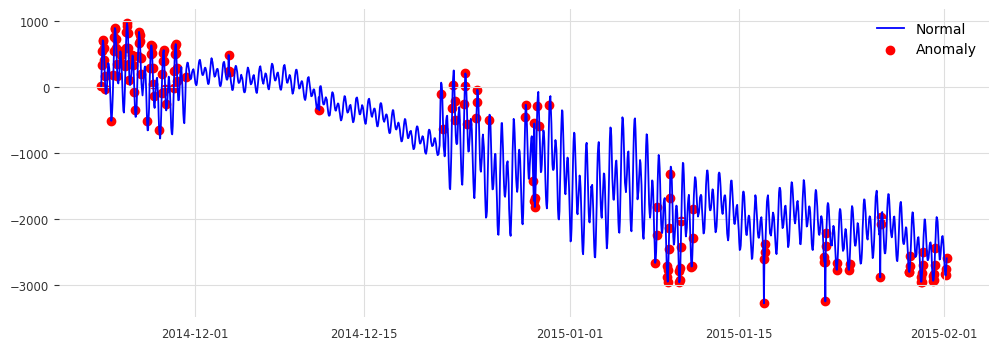

In [33]:
plot_outlier(suod_prediction_df)

In [34]:
print_metrics(df, suod_prediction_df)

F1 Score: 0.07407407407407407
Recall: 1.0
Precision: 0.038461538461538464


## XGBOOST

In [11]:
xgb_clf = XGBOD(n_jobs=4)
for i in np.array_split(validate_df, 6):
    xgb_clf.fit(i.drop('label', axis=1), i['label'])

[09:23:56] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:25:49] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:27:38] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

In [22]:
xgb_prediction_df = data.copy()
# xgb_prediction_df['score'] = xgb_clf.decision_scores_ # outlier score
# ae_prediction_df['prediction'] = np.where(ae_prediction_df['score'] < 4.8, 0, 1)
xgb_prediction_df['prediction'] = xgb_clf.predict(data.drop('label', axis=1))
xgb_prediction_df['prediction'].value_counts()
# df['label'].value_counts()
# ae_prediction_df.groupby('prediction').mean()

1    1680
Name: prediction, dtype: int64

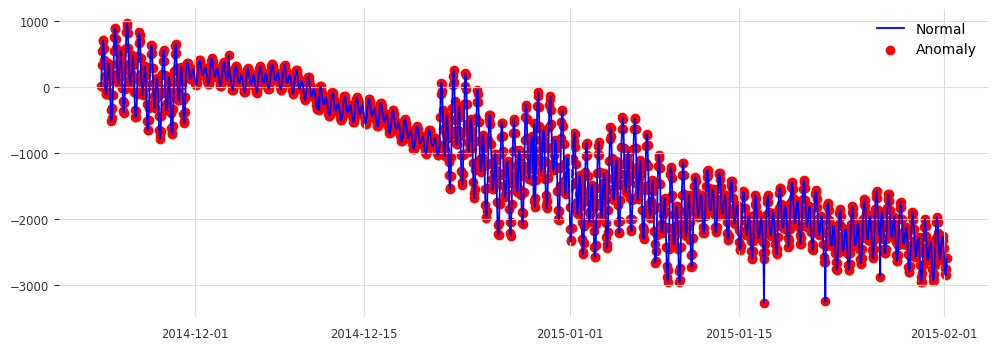

In [23]:
plot_outlier(xgb_prediction_df)

In [24]:
print_metrics(df, xgb_prediction_df)

F1 Score: 0.0071174377224199285
Recall: 1.0
Precision: 0.0035714285714285713


## IsolationForest

In [12]:
outliers_fraction = float(.03)
if_model =  IsolationForest(contamination=outliers_fraction)
if_model.fit(data)

/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.03)

In [13]:
if_prediction_df = df.copy()
if_prediction_df['anomaly'] = if_model.predict(data)
if_prediction_df['prediction'] = np.where(if_prediction_df['anomaly']==-1, 1, 0)
if_prediction_df['prediction'].value_counts()

0    1629
1      51
Name: prediction, dtype: int64

#### Visualization

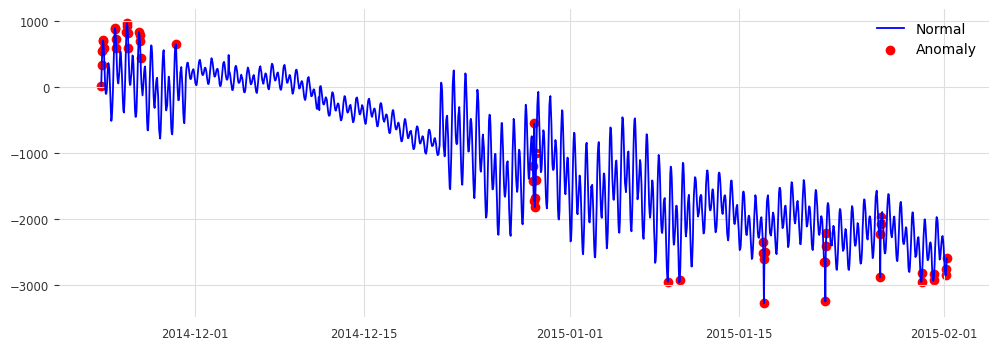

In [14]:
plot_outlier(if_prediction_df)

#### Metrics

In [15]:
print_metrics(df, if_prediction_df)

F1 Score: 0.14035087719298245
Recall: 0.6666666666666666
Precision: 0.0784313725490196


## KNN

In [16]:
outliers_fraction = float(0.03)
knn_model =  KNN(contamination=outliers_fraction)
knn_model.fit(data)

KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [17]:
knn_prediction_df = df.copy()
knn_prediction_df['anomaly'] = knn_model.predict(data)
knn_prediction_df['prediction'] = np.where(knn_prediction_df['anomaly']==1, 1, 0)
knn_prediction_df['prediction'].value_counts()

0    1639
1      41
Name: prediction, dtype: int64

#### Visualization

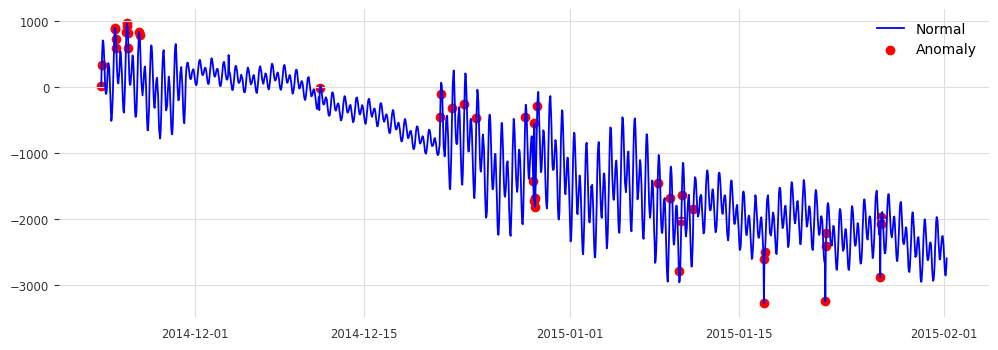

In [18]:
plot_outlier(knn_prediction_df)

#### Metrics

In [19]:
print_metrics(df, knn_prediction_df)

F1 Score: 0.1702127659574468
Recall: 0.6666666666666666
Precision: 0.0975609756097561


## DBSCAN

In [19]:
dbscan_model = DBSCAN()
dbscan_model.fit(data)

DBSCAN()

In [20]:
dbscan_predicted = data.copy()
dbscan_predicted['anomaly'] = dbscan_model.labels_
dbscan_predicted['prediction'] = np.where(dbscan_predicted['anomaly']==-1, 1, 0)

#### Visualization

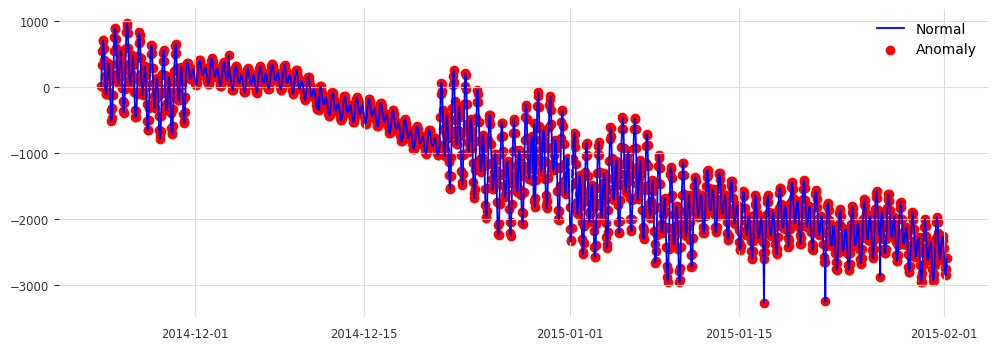

In [21]:
plot_outlier(dbscan_predicted)

#### Metrics

In [22]:
print_metrics(df, dbscan_predicted)

F1 Score: 0.0071174377224199285
Recall: 1.0
Precision: 0.0035714285714285713


## AutoregressionAD

In [41]:
autoregression_ad = AutoregressionAD(n_steps=60, step_size=1, c=6.0)
anomalies = autoregression_ad.fit_detect(validate_df)

In [42]:
anomalies['prediction'] = np.where(anomalies['resid']==True, 1, 0)

#### Visualization

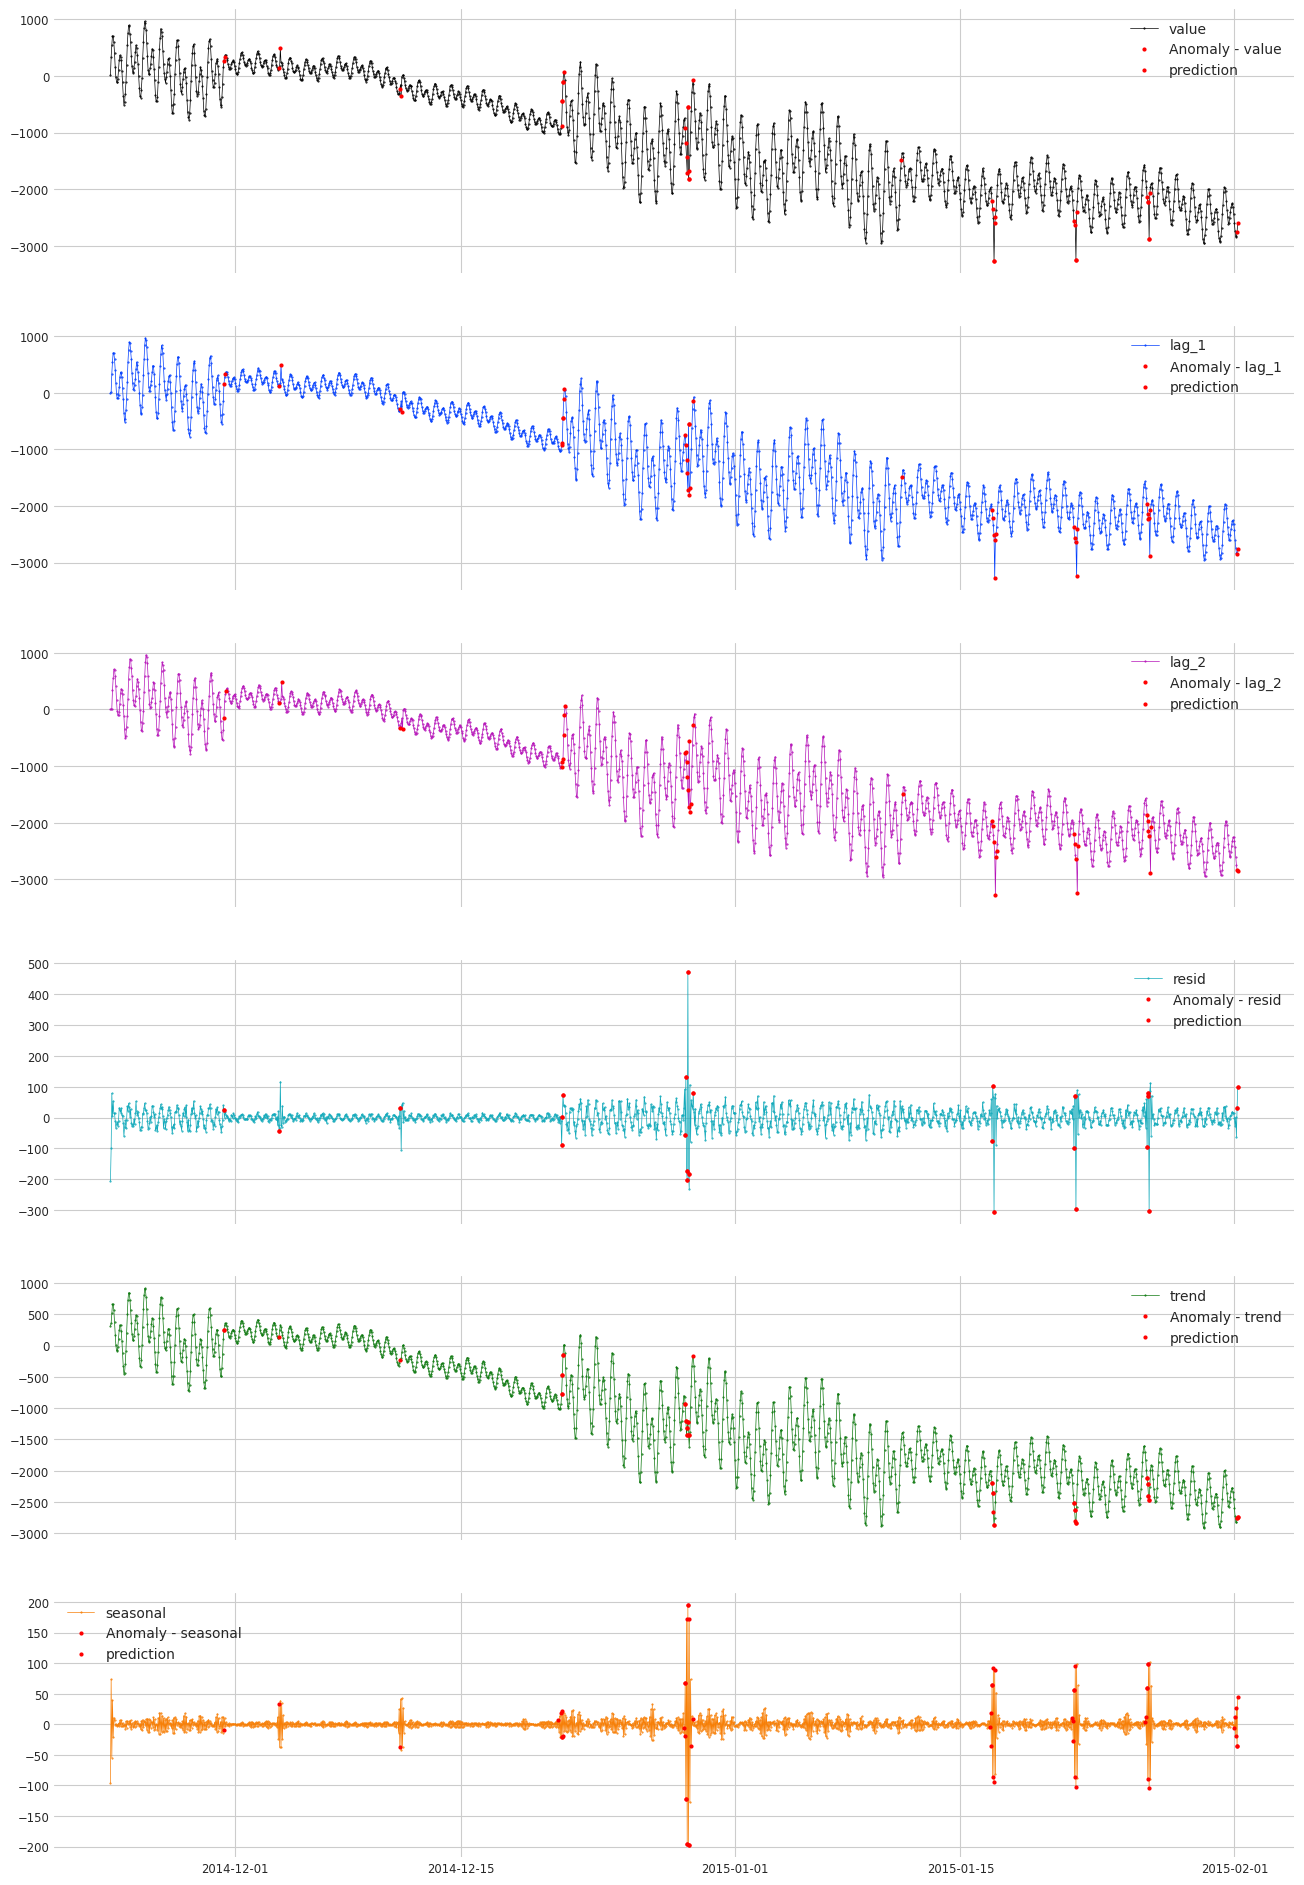

In [43]:
plot(validate_df, anomaly=anomalies, ts_markersize=1, anomaly_color='red', anomaly_tag="marker", anomaly_markersize=2);

#### Metrics

In [44]:
print_metrics(df, anomalies)

F1 Score: 0.25806451612903225
Recall: 0.6666666666666666
Precision: 0.16


## QuantileAD

In [11]:
quantile_ad = QuantileAD(high=0.999, low=0.001)
anomalies = quantile_ad.fit_detect(validate_df)

In [12]:
anomalies['prediction'] = np.where(anomalies['resid']==True, 1, 0)

#### Visualization

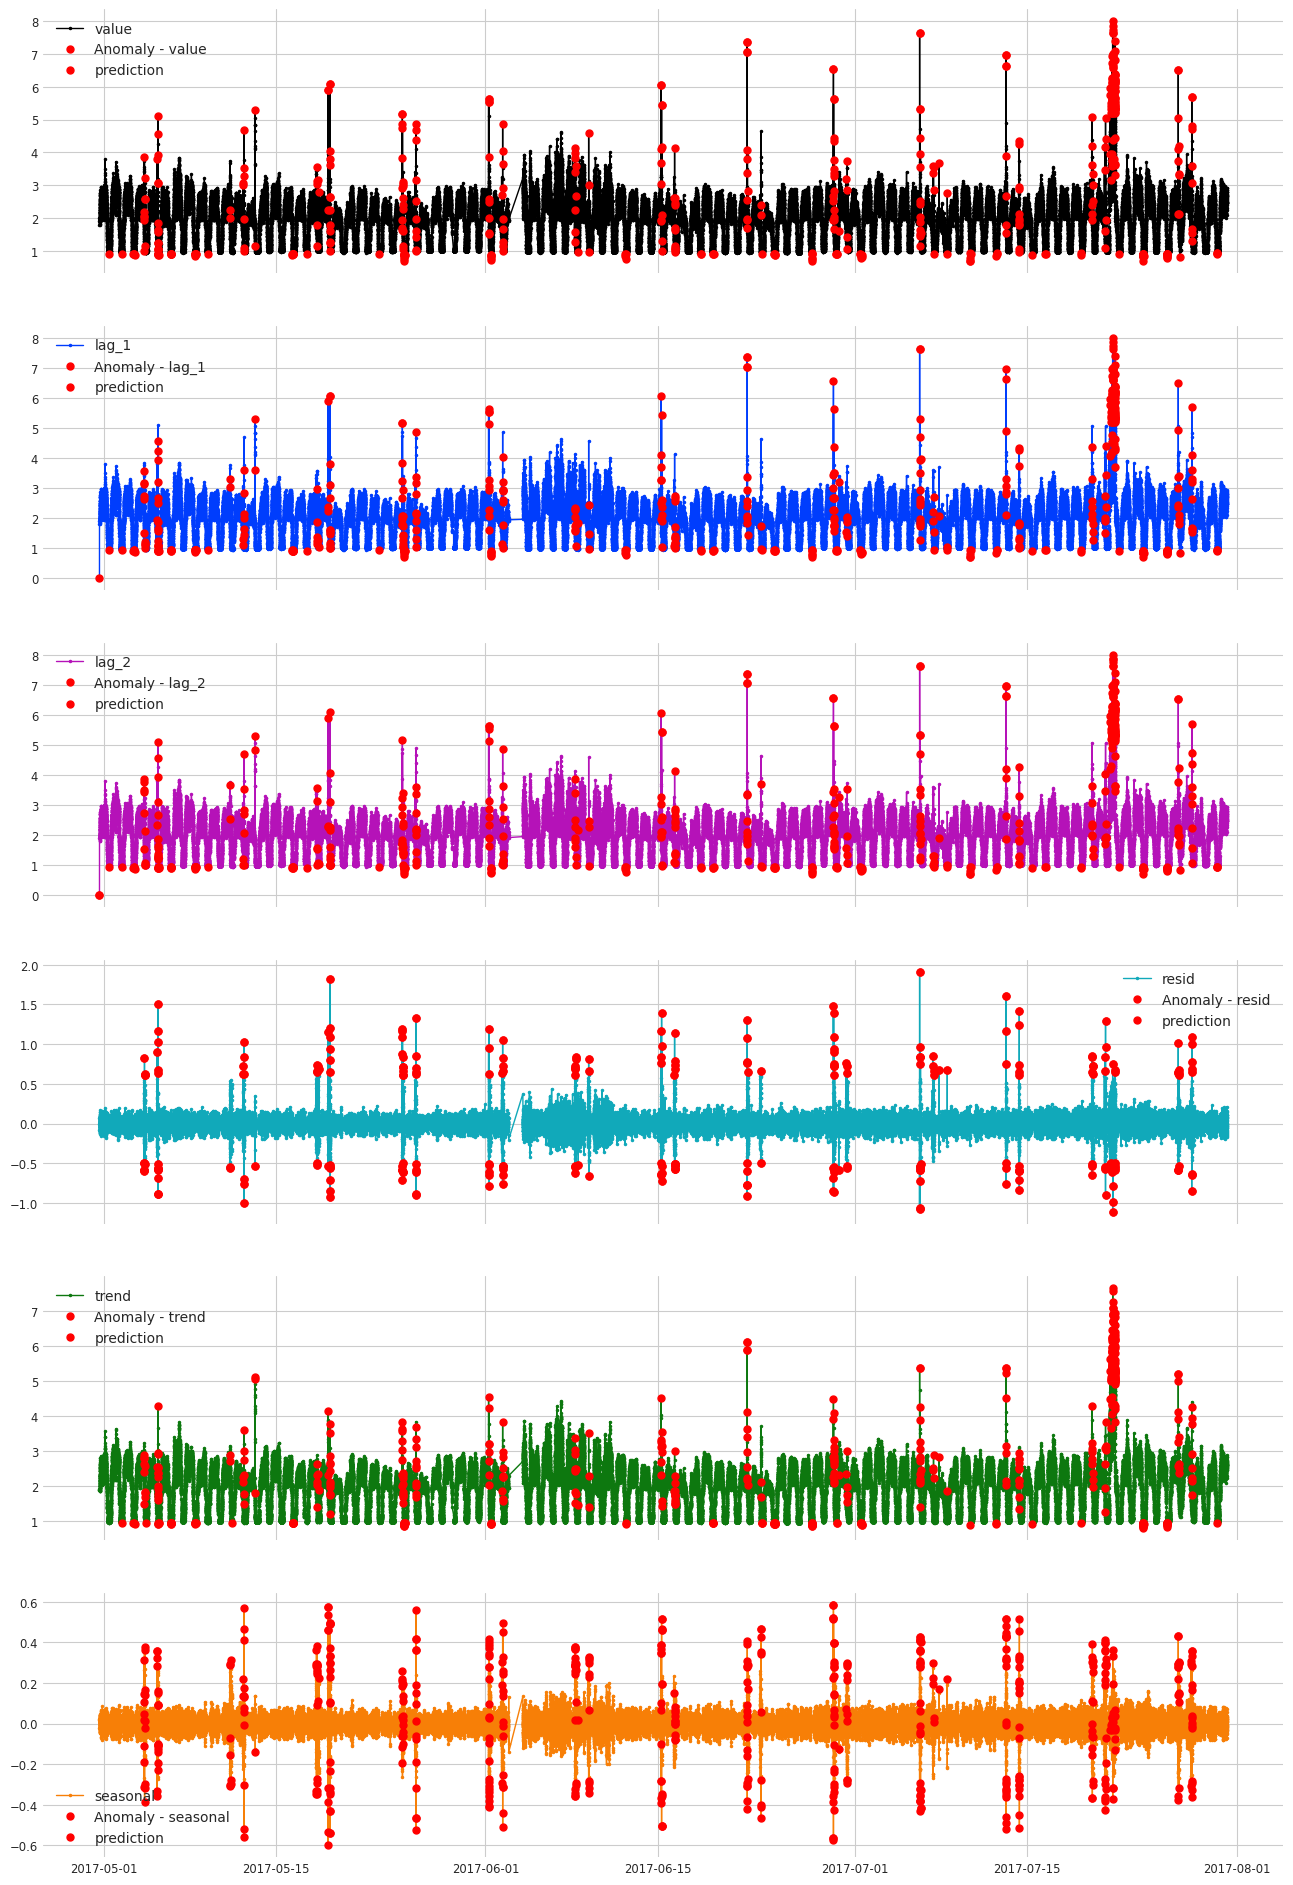

In [13]:
plot(validate_df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

#### Metrics

In [14]:
print_metrics(df, anomalies)

F1 Score: 0.04644707623982235
Recall: 0.023791469194312798
Precision: 0.9728682170542635


## InterQuartileRangeAD

In [15]:
iqr_ad = InterQuartileRangeAD(c=5)
anomalies = iqr_ad.fit_detect(validate_df)

In [16]:
anomalies['prediction'] = np.where(anomalies['resid']==True, 1, 0)

#### Visualization

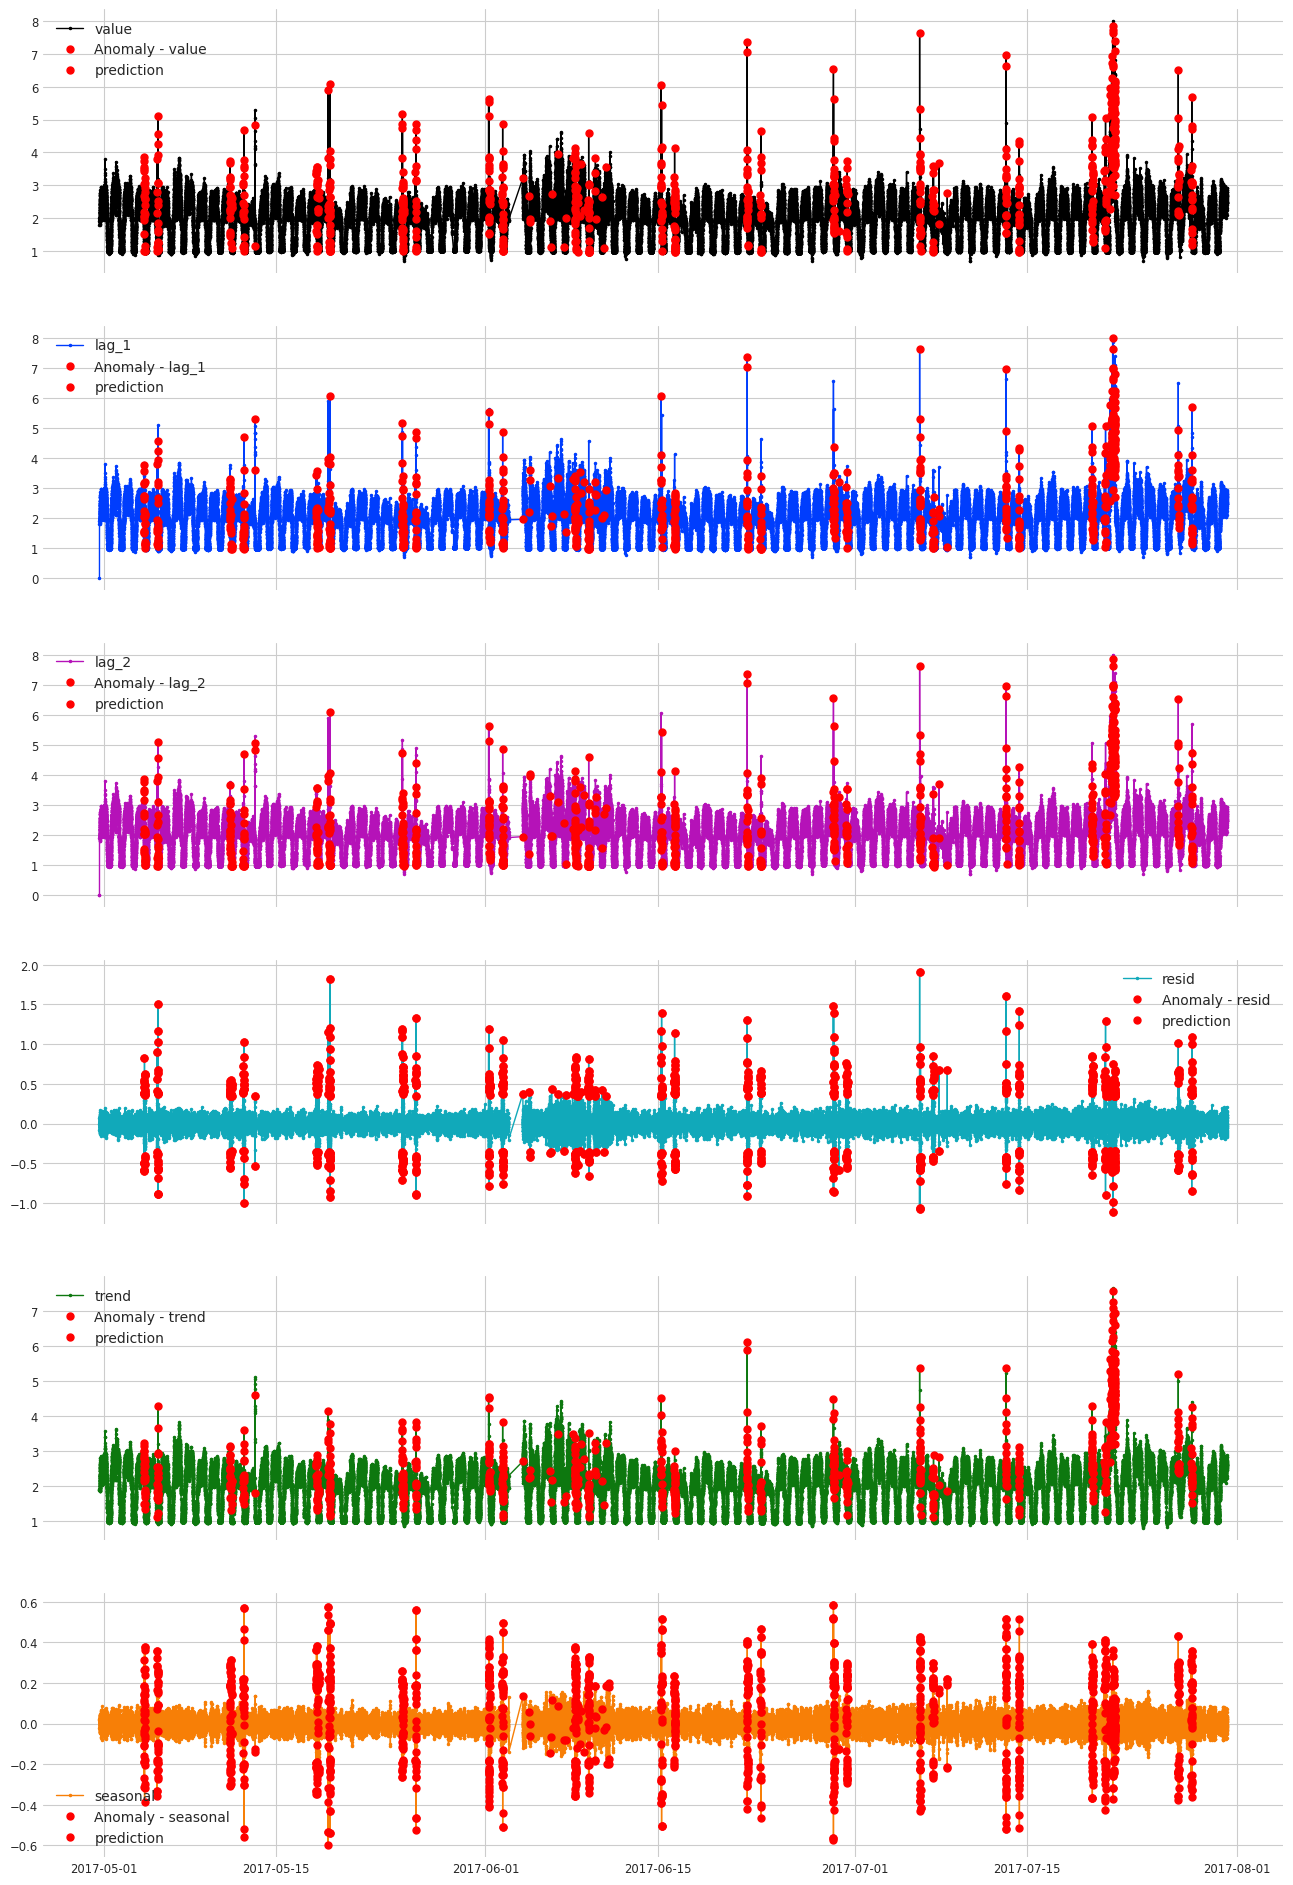

In [17]:
plot(validate_df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

#### Metrics

In [18]:
print_metrics(df, anomalies)

F1 Score: 0.13177677544883698
Recall: 0.07061611374407582
Precision: 0.9841479524438573


## GeneralizedESDTestAD

In [19]:
esd_ad = GeneralizedESDTestAD(alpha=0.5)
anomalies = esd_ad.fit_detect(validate_df)

In [20]:
anomalies['prediction'] = np.where(anomalies['resid']==True, 1, 0)

#### Visualization

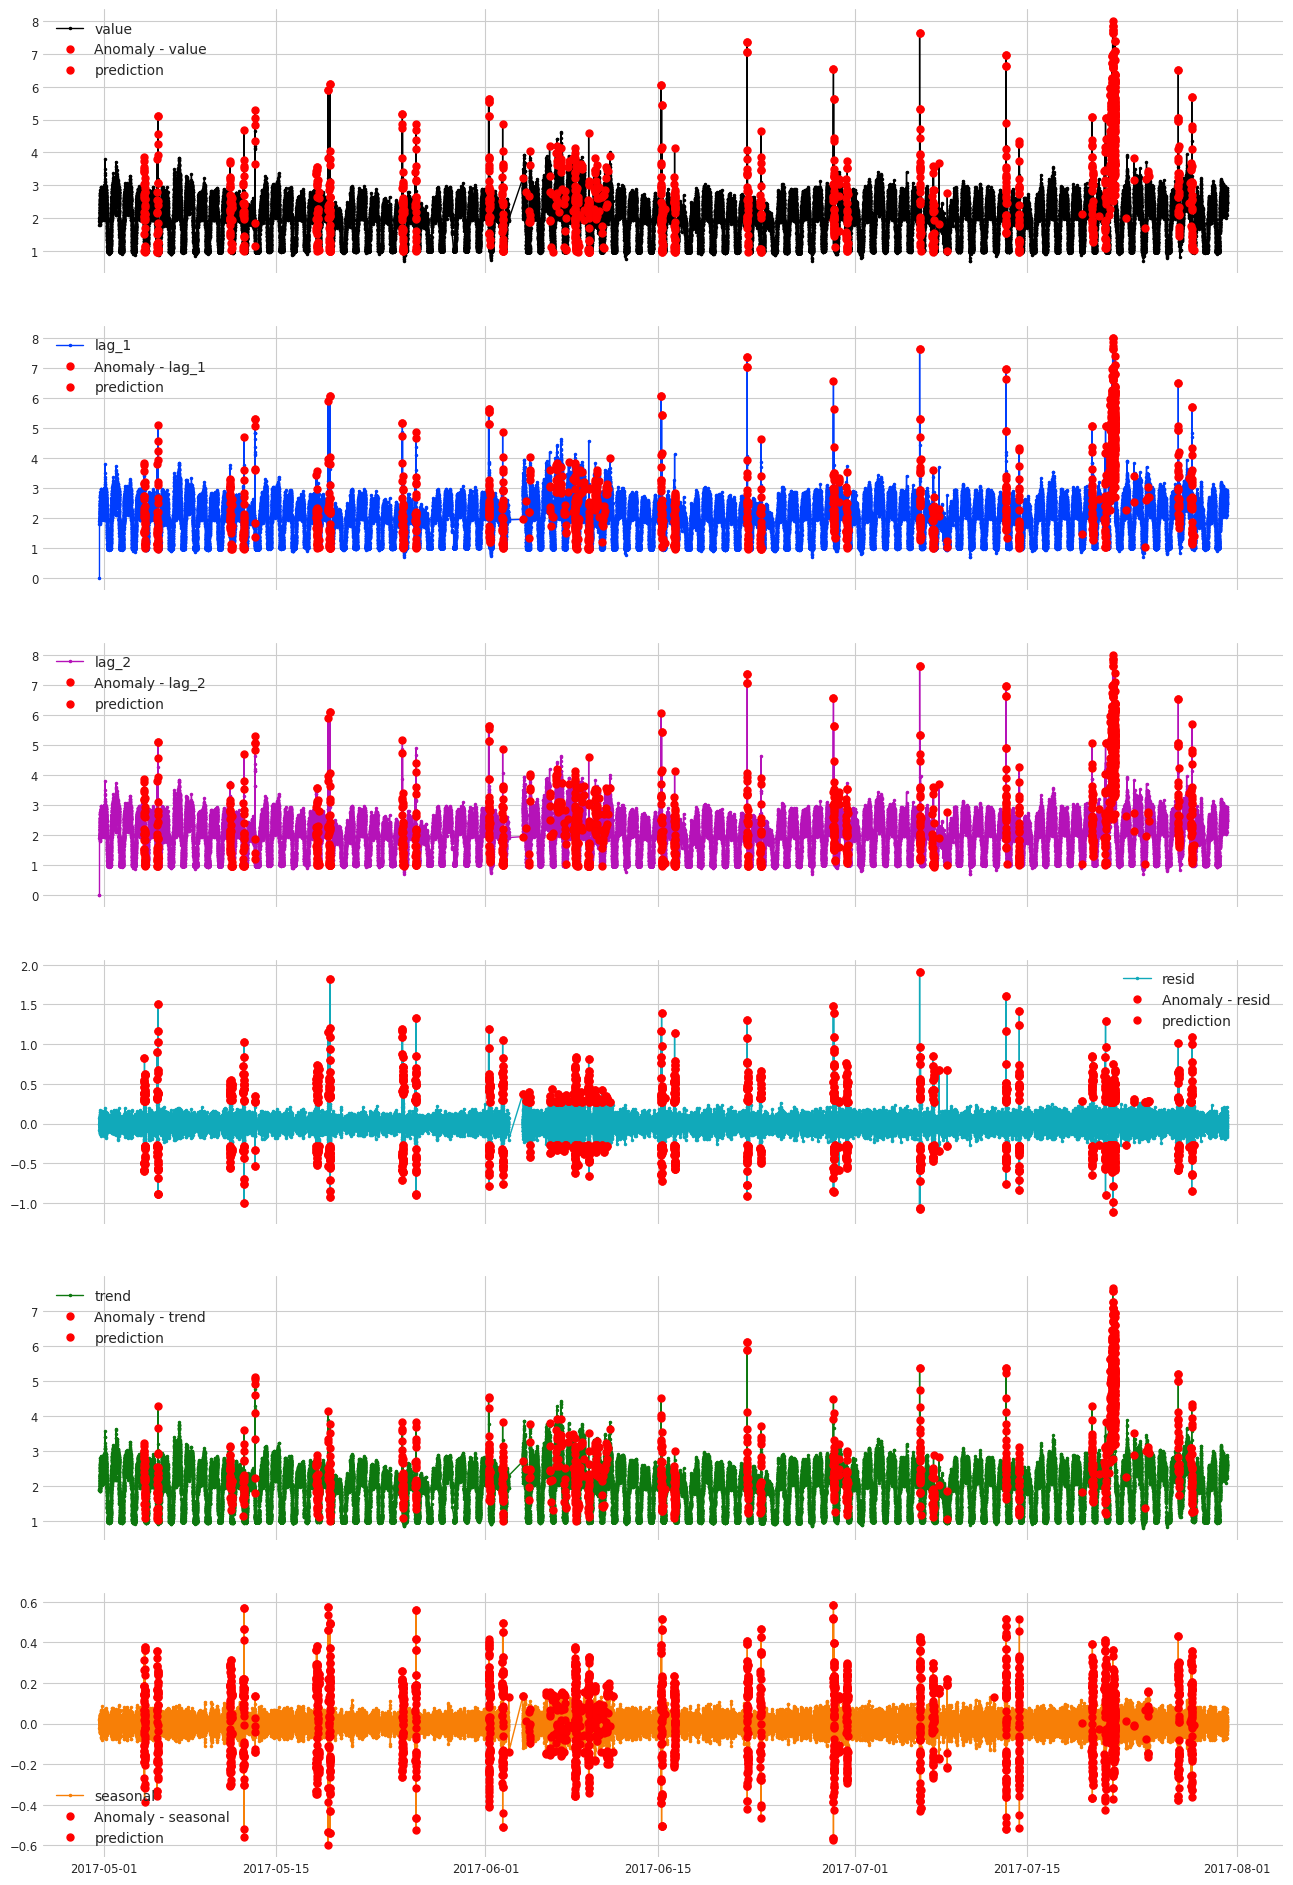

In [21]:
plot(validate_df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

#### Metrics

In [22]:
print_metrics(df, anomalies)

F1 Score: 0.1945817004600443
Recall: 0.10824644549763034
Precision: 0.9612794612794613


## PersistAD

In [78]:
persist_ad = PersistAD(c=5.0, side='positive')
anomalies = persist_ad.fit_detect(validate_df)

In [79]:
anomalies['prediction'] = np.where(anomalies['resid']==True, 1, 0)

#### Visualization

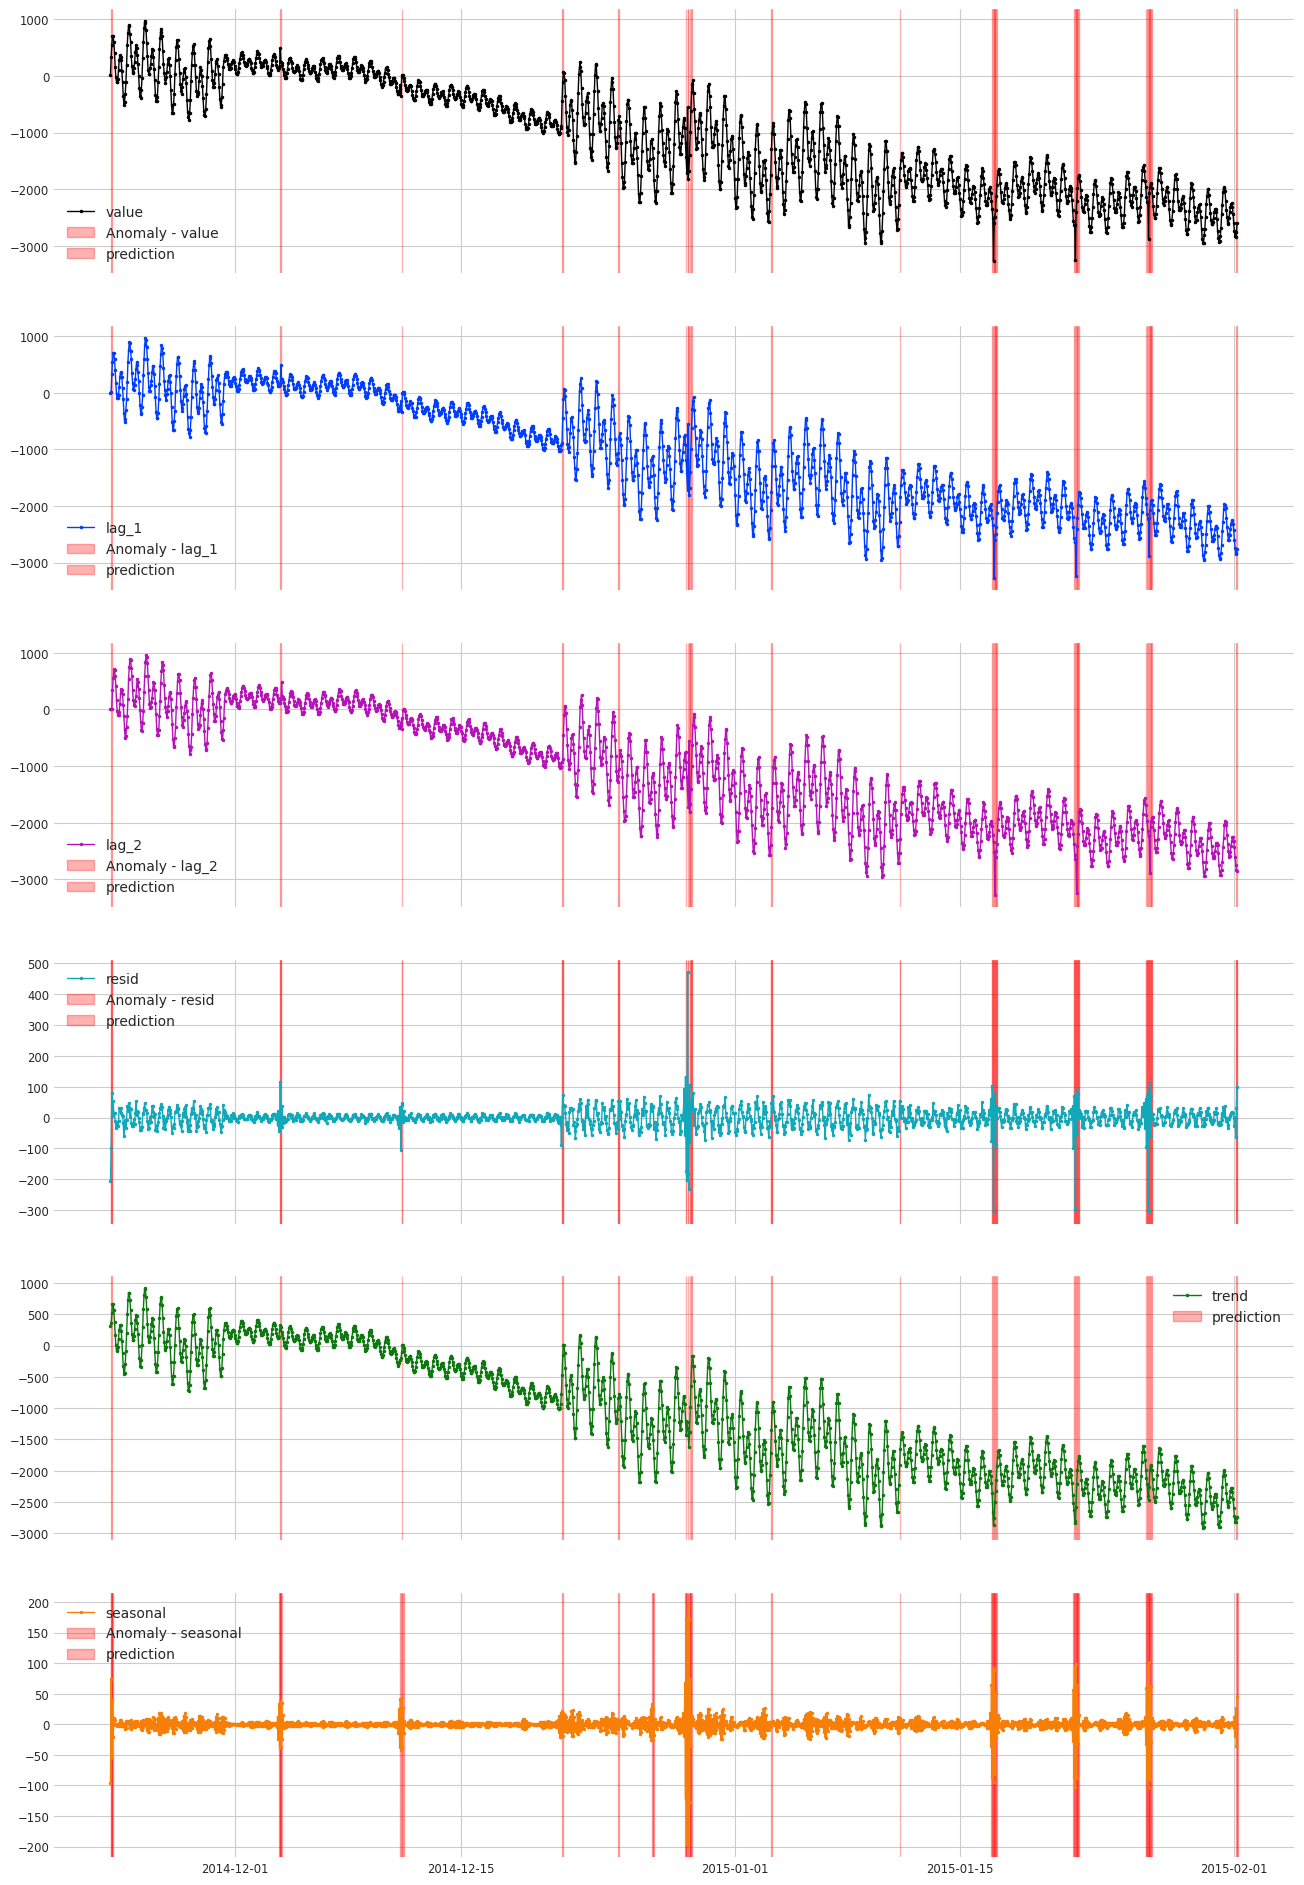

In [80]:
plot(validate_df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red');

#### Metrics

In [81]:
print_metrics(df, anomalies)

F1 Score: 0.13793103448275862
Recall: 0.3333333333333333
Precision: 0.08695652173913043


##### By default, PersistAD only check one previous value, which is good at capturing additive anomaly in short-term scale, but not in long-term scale because it is too near-sighted. In the following example, it fails to capture meaningful drops of price in a longer time scale.

In [27]:
persist_ad = PersistAD(c=2, side='both')
persist_ad.window = 20
anomalies = persist_ad.fit_detect(validate_df)

In [28]:
anomalies['prediction'] = np.where(anomalies['resid']==True, 1, 0)

#### Visualization

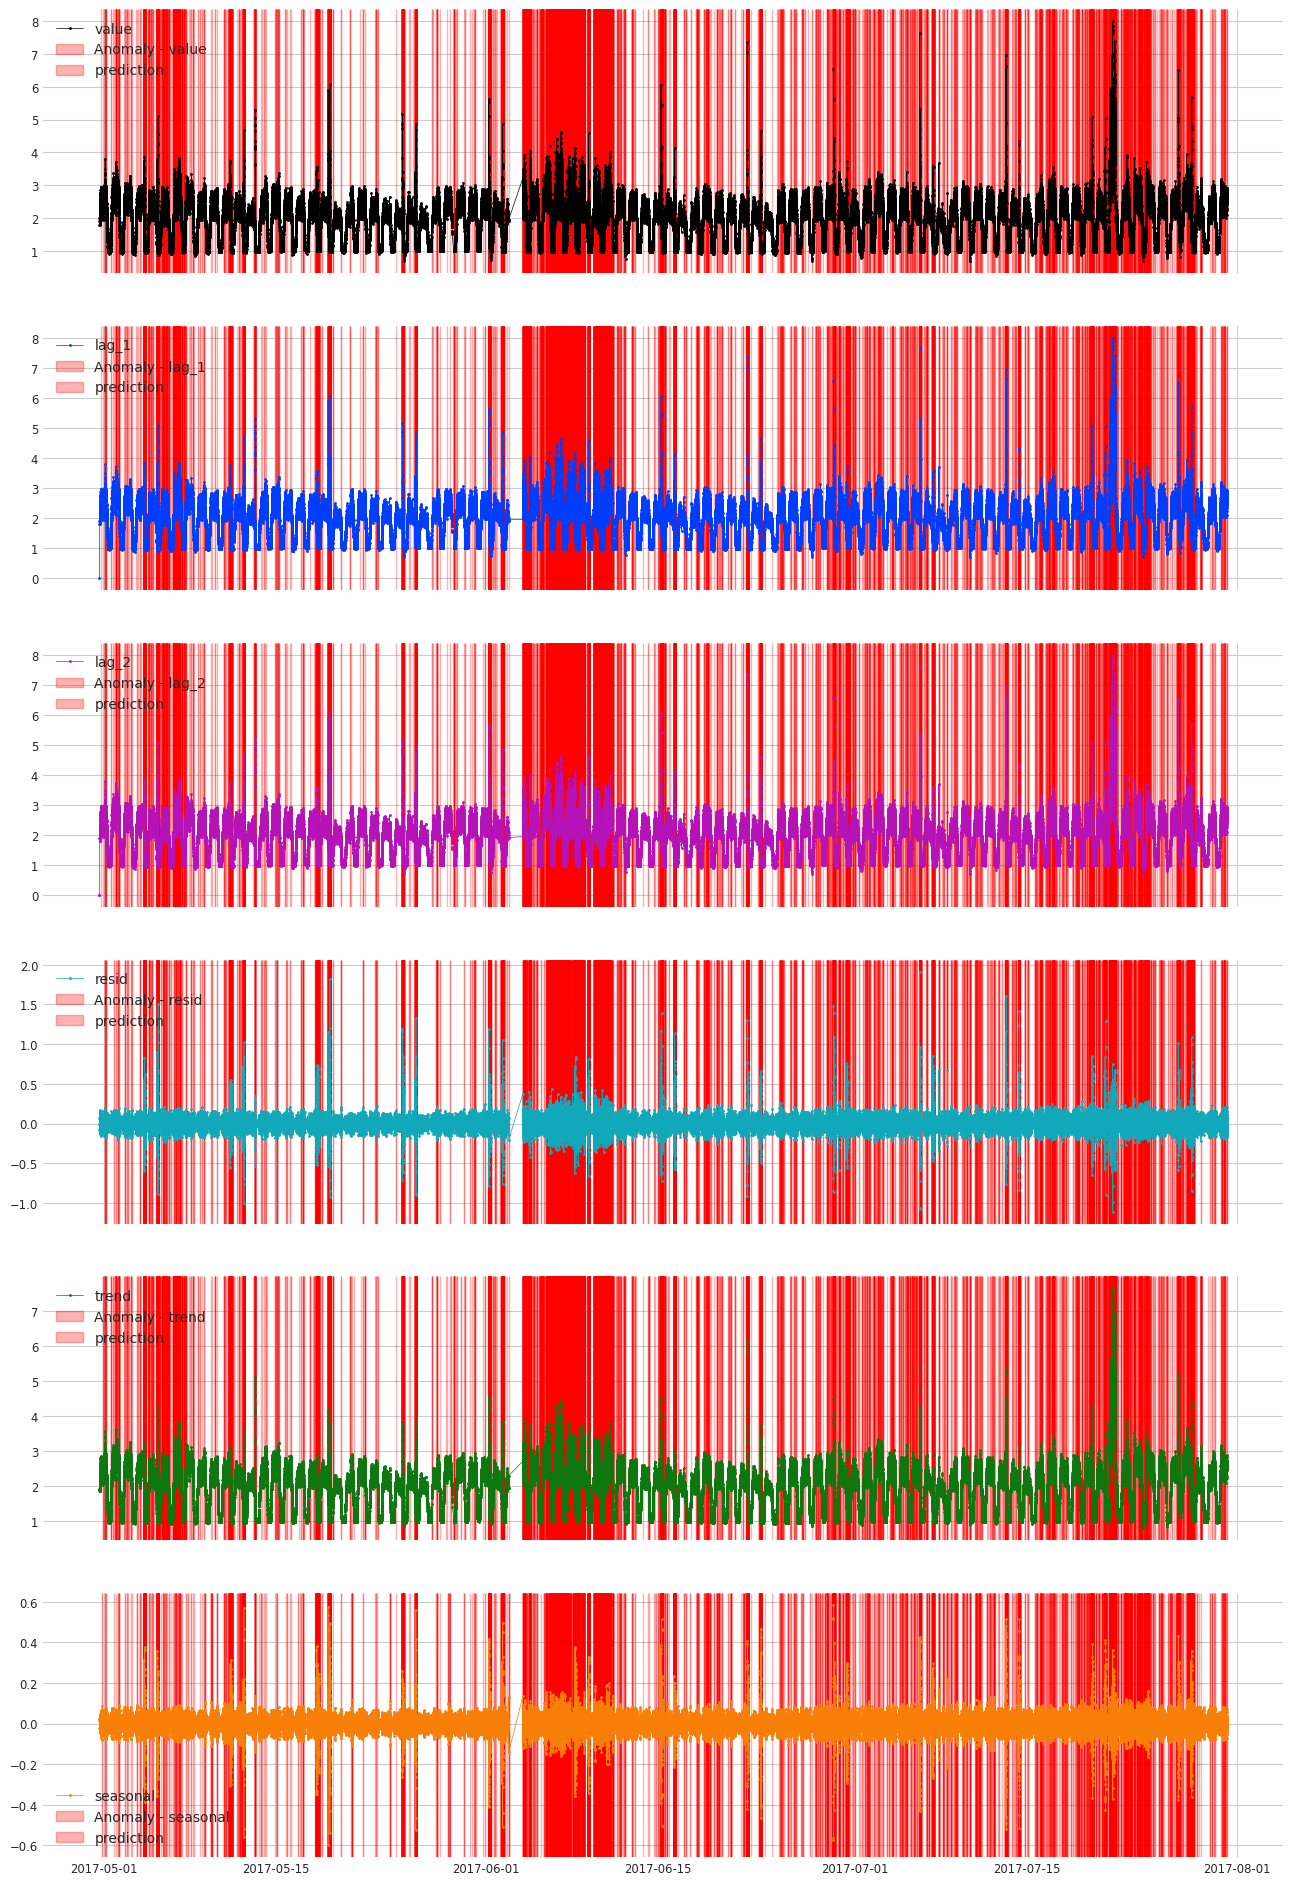

In [29]:
plot(validate_df, anomaly=anomalies, anomaly_color='red');

#### Metrics

In [30]:
print_metrics(df, anomalies)

F1 Score: 0.342512908777969
Recall: 0.22635071090047393
Precision: 0.703594578668238


## LevelShiftAD

In [47]:
level_shift_ad = LevelShiftAD(c=6.0, side='both', window=5)
anomalies = level_shift_ad.fit_detect(validate_df)

In [48]:
anomalies['prediction'] = np.where(anomalies.iloc[:, 0]==True, 1, 0)

#### Visualization

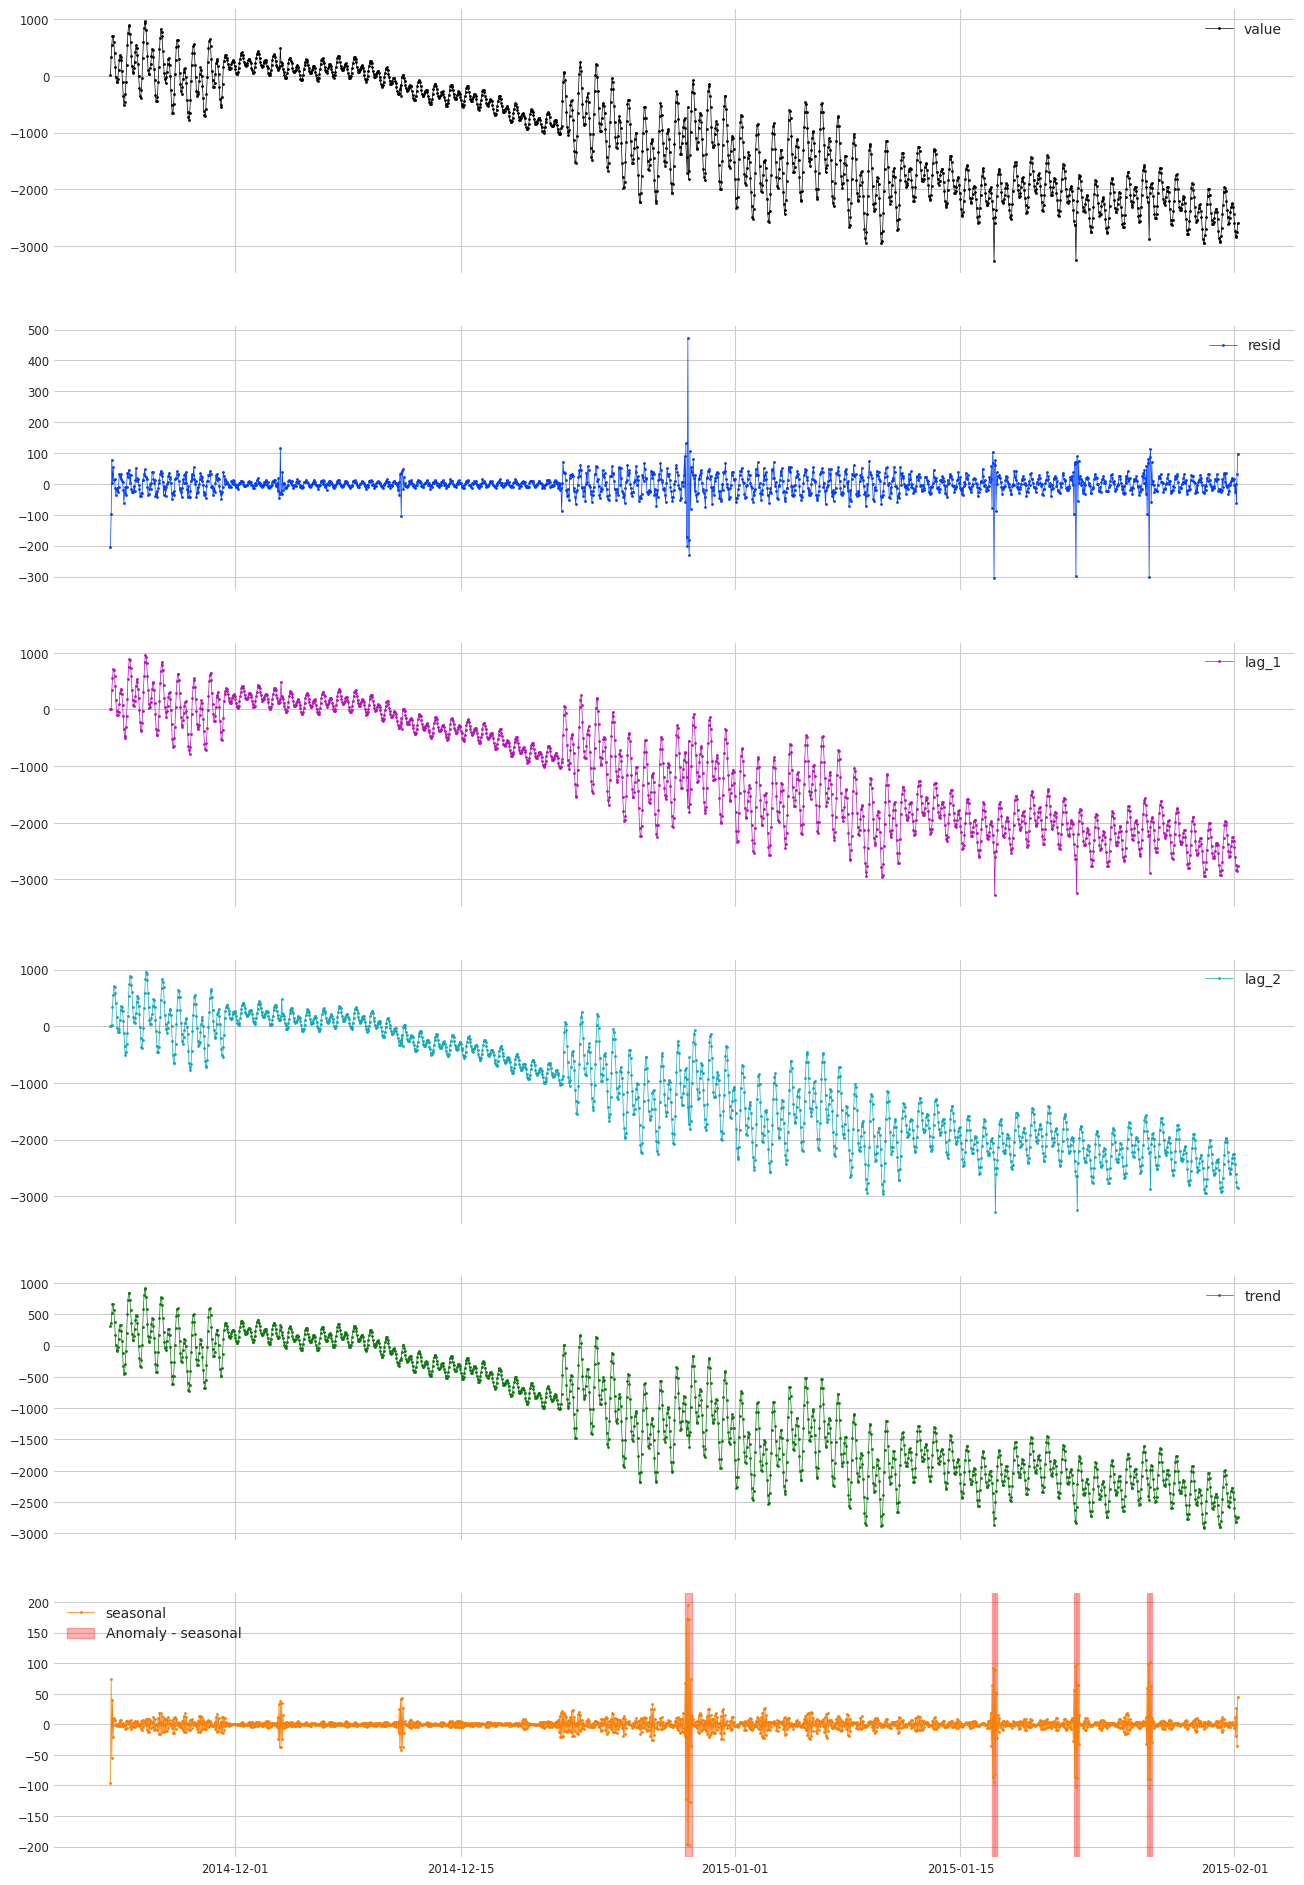

In [49]:
plot(validate_df, anomaly=anomalies, anomaly_color='red');

#### Metrics

In [50]:
print_metrics(df, anomalies)

F1 Score: 0.0
Recall: 0.0
Precision: 0.0


/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## VolatilityShiftAD

In [51]:
volatility_shift_ad = VolatilityShiftAD(c=6.0, side='positive', window=30)
anomalies = volatility_shift_ad.fit_detect(validate_df)

In [52]:
anomalies['prediction'] = np.where(anomalies.iloc[:, 0]==True, 1, 0)

#### Visualization

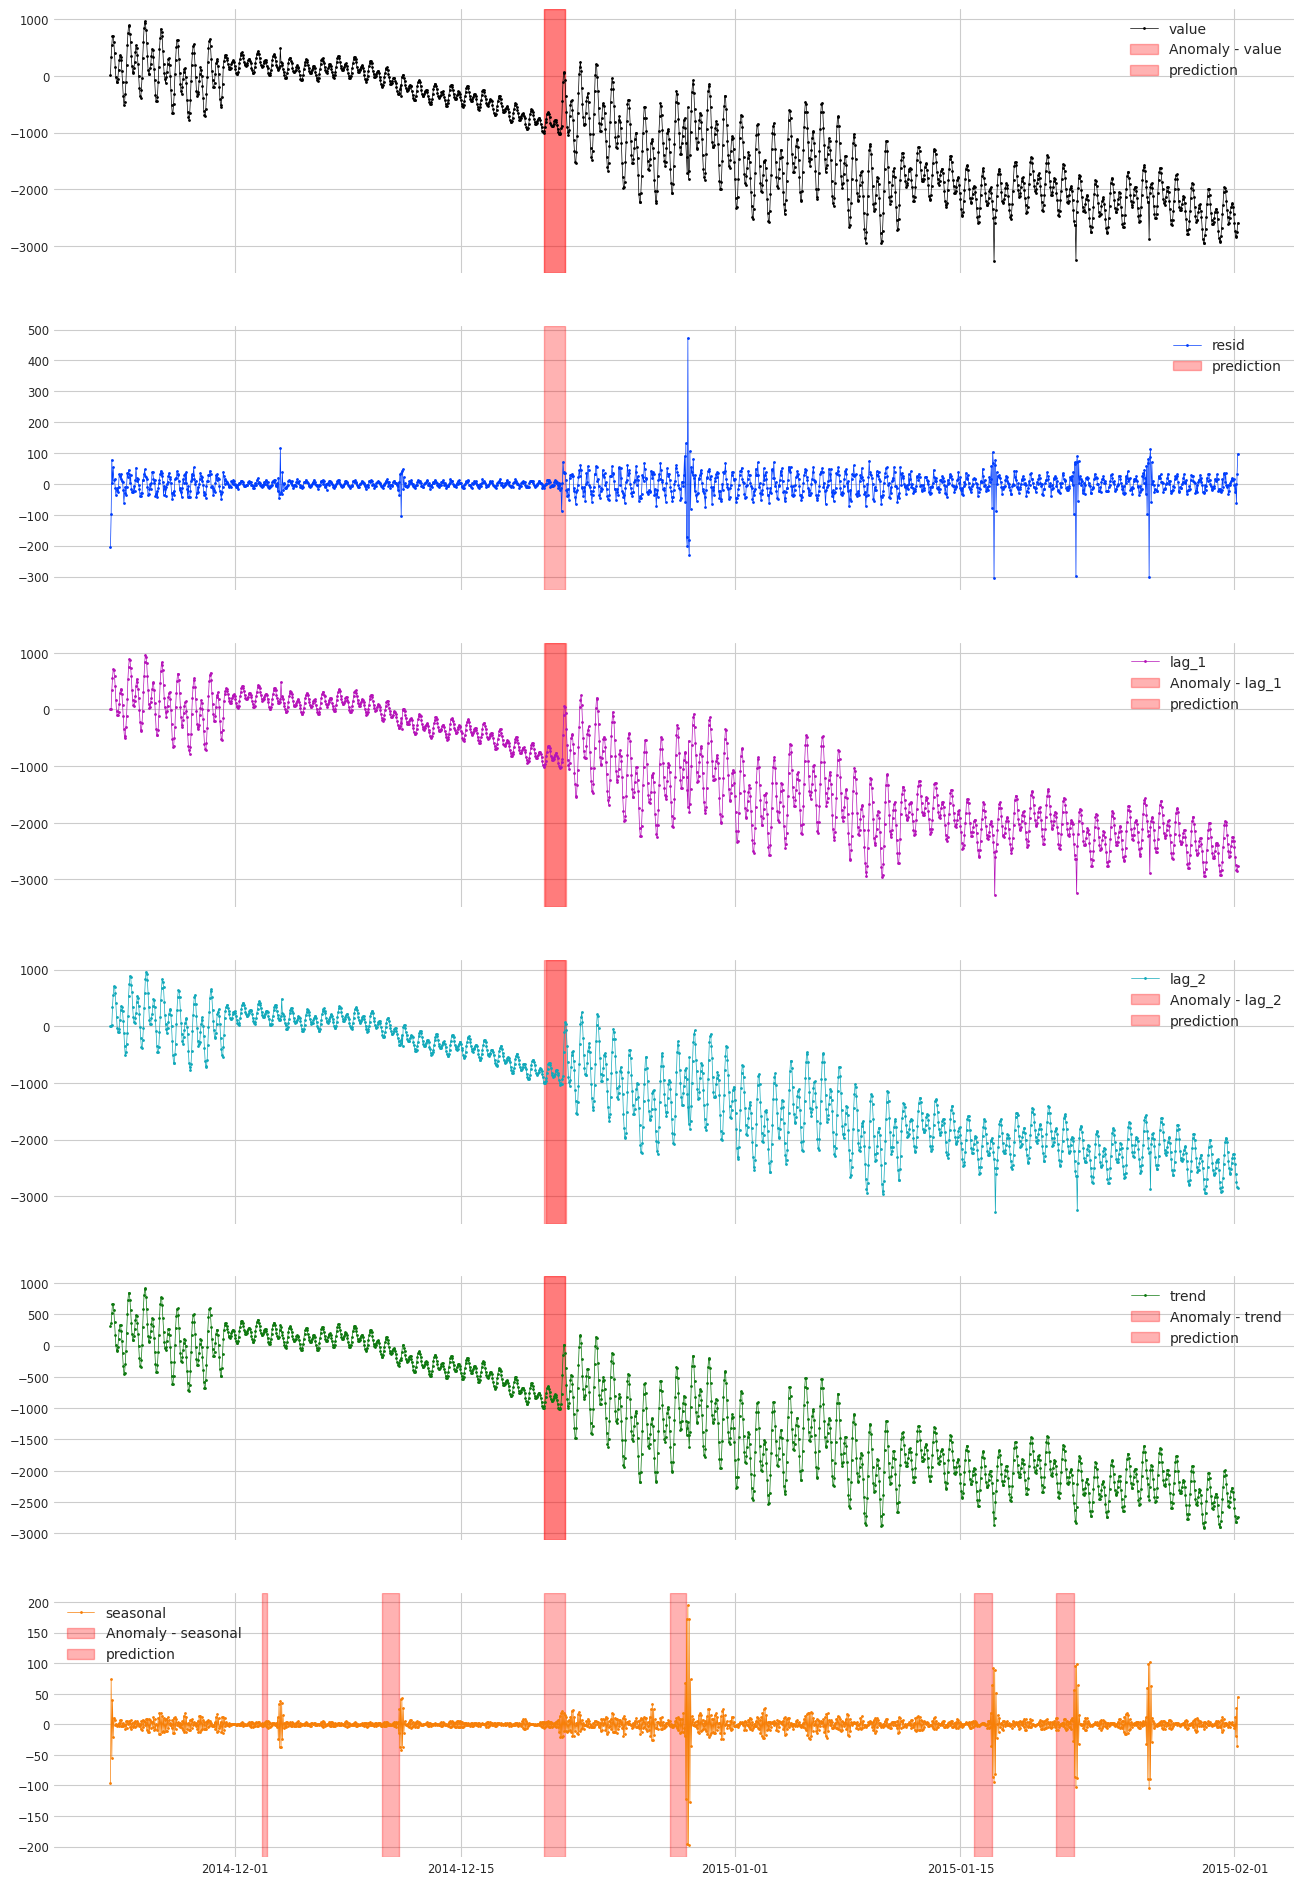

In [53]:
plot(validate_df, anomaly=anomalies, anomaly_color='red');

#### Metrics

In [54]:
print_metrics(df, anomalies)

F1 Score: 0.0
Recall: 0.0
Precision: 0.0


## MinClusterDetector

In [55]:
# This is more used in multivariate timeseries
min_cluster_detector = MinClusterDetector(KMeans(n_clusters=3))
anomalies = min_cluster_detector.fit_detect(data)

#### Visualization

[<AxesSubplot:>]

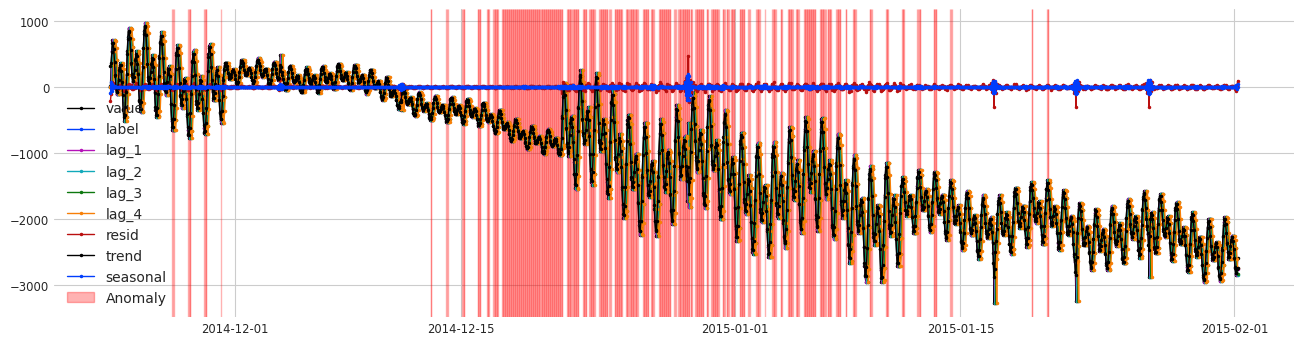

In [56]:
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')

In [57]:
anomalies['prediction'] = np.where(anomalies==True, 1, 0)

#### Metrics

In [58]:
print_metrics(df, anomalies)

F1 Score: 0.004694835680751174
Recall: 0.16666666666666666
Precision: 0.002380952380952381


## PcaAD

In [11]:
pca_ad = PcaAD(k=1)
anomalies = pca_ad.fit_detect(data)

#### Visualization

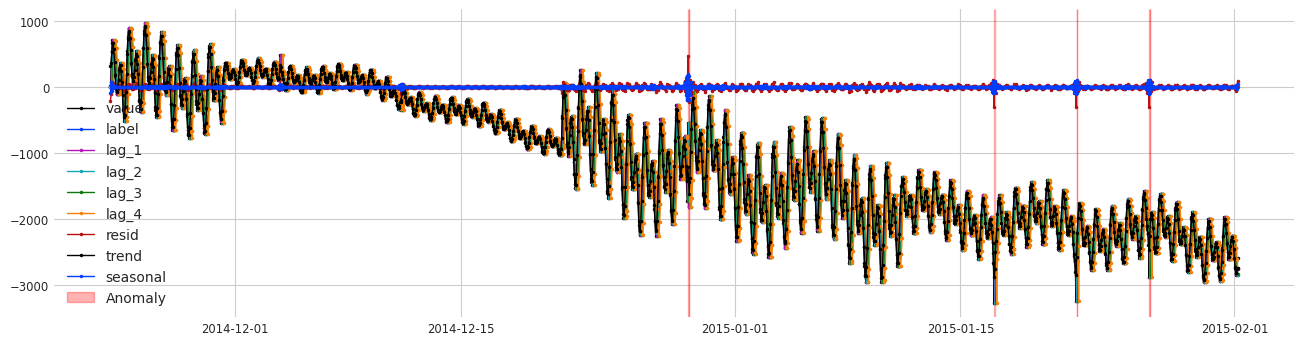

In [12]:
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

In [13]:
anomalies['prediction'] = np.where(anomalies==True, 1, 0)

#### Metrics

In [14]:
print_metrics(df, anomalies)

F1 Score: 0.37499999999999994
Recall: 0.5
Precision: 0.3


## Pipeline

In [63]:
from adtk.pipe import Pipeline
from adtk.transformer import ClassicSeasonalDecomposition
steps = [
    ("deseasonal", ClassicSeasonalDecomposition()),
    ("quantile_ad", QuantileAD(high=0.995, low=0.005))
]
pipeline = Pipeline(steps)

In [64]:
# s = validate_series(s)
# anomalies = pipeline.fit_detect(s)
# plot(s, anomaly=anomalies, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');

## Kats

In [65]:
from kats.detectors.outlier import OutlierDetector

ts_outlierDetection = OutlierDetector(validate_df, 'additive') # call OutlierDetector
ts_outlierDetection.detector() # apply OutlierDetector

ModuleNotFoundError: No module named 'kats'

In [ ]:
ts_outlierDetection.outliers[0]

In [ ]:
air_passengers_ts_outliers_removed = ts_outlierDetection.remover(interpolate = False) # No interpolation
air_passengers_ts_outliers_interpolated = ts_outlierDetection.remover(interpolate = True) # With interpolation

In [ ]:
fig, ax = plt.subplots(figsize=(20,8), nrows=1, ncols=2)
air_passengers_ts_outliers_removed.to_dataframe().plot(x = 'time',y = 'y_0', ax= ax[0])
ax[0].set_title("Outliers Removed : No interpolation")
air_passengers_ts_outliers_interpolated.to_dataframe().plot(x = 'time',y = 'y_0', ax= ax[1])
ax[1].set_title("Outliers Removed : With interpolation")
plt.show()

## pyfbad Anomaly detection

In [ ]:
# import plotly.express as px
# from plotly.offline import iplot
# from pyfbad.data import database as db
# from pyfbad.models import models as md
# from pyfbad.features import create_feature as cf
# from pyfbad.notification import notifications as ntf